# Bibliotecas e Leitura da Entrada

In [ ]:
!pip install Unidecode

In [ ]:
!pip install vaderSentiment

In [1]:
import nltk
import re
import unidecode
import json
import pickle

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 500)

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Analisador de sentimento pt-br
from vaderSentimentPtbr.vaderSentiment import SentimentIntensityAnalyzer

# Lista os inputs
from subprocess import check_output
print(check_output(["ls", "-l", "inputs"]).decode("utf8"))

# Plots
import matplotlib.pyplot as plt

total 2484
-rw-rw-r-- 1 chavell chavell 2391640 Set 28 02:08 clarobrasil.json
-rw-r--r-- 1 chavell chavell  142569 Set 22 20:42 sample1_tweets_en.json



In [2]:
# Leitura do arquivo JSON para DataFrame
tweets = []
for line in open('inputs/clarobrasil.json', 'r'):
    tweets.append(json.loads(line))
    
aux_tweets = []
for i in tweets:
    aux_tweets.append([i['original_post_id'], i['screen_name'], i['text'], i['replies']])
    
df_tweets = pd.DataFrame(aux_tweets)

Após a leitura do JSON e a conversão para DataFrame, temos uma estrutura com o seguinte formato:

In [3]:
df_tweets.head()

0            1  \
0  1040362106208571393  ClaroBrasil   
1  1040367745060294656  ClaroBrasil   
2  1040366339788087298  ClaroBrasil   
3  1040366493366673410  ClaroBrasil   
4  1040370756817965058  ClaroBrasil   

                                                                                                                                         2  \
0         @carolgil Olá! Você pode ativar a legenda através do seu controle remoto, tudo bem? Qualquer outra dúvida, estamos à disposição!   
1                                      @FannyCristine7 Olá. Por gentileza, nos dê mais detalhes do que está acontecendo. Iremos te ajudar!   
2  @lleandro089 Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos ajudar por telefone!   
3                                                                                                                   @eedmir Conte conosco!   
4                                                                    @FgDDeus22 Olá. Está precisando da nossa ajuda? Estamos à disposição.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     3  
0                                                                                                                                                                                                                            [Por que diabos a @WarnerChannelBR tirou a opção de legenda em todos os programas?! Não é possível que seja uma escolha da ClaroBrasil retirar essa alternativa., Olá! Você pode ativar a legenda através do seu controle remoto, tudo bem? Qualquer outra dúvida, estamos à disposição!]  
1                                                                                                                                                                                                                                                                                                                                                                                      [Essa internet da claro ta cada vez pior., Olá. Por gentileza, nos dê mais detalhes do que está acontecendo. Iremos te ajudar!]  
2  [, , Estou pagando por ponto adicional e essa cobrança pela @anatel_oficial não deveria existir. E em contato caso deixe de pagar perco os benefícios do pacote., Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos ajudar por telefone!, Cadê o contato que informaram? Até agora não recebi nenhuma ligação, Leandro, seu caso está em análise. Entraremos em contato o mais breve possível., Pois é, recebi ligação dizendo que a cobrança de ponto é dev...  
3                                                                                                                                                                                                                                                                                                                                                                        [, , , , Assim espero, como falei antes, cansei de tanto fazer solicitações, esperarei até o final do ciclo da fatura atual., Conte conosco!]  
4                                                                                                                                                                                                                                                                             [Minha internet acaba amanhã diz a claro puts, Olá. Está precisando da nossa ajuda? Estamos à disposição., Sim , a ajuda que eu quero é co

Formato da base de dados e quantidade de nans por coluna:

In [4]:
print('Quantidade de tweets:', df_tweets.shape[0], '\n')
print('Quantidade de valores faltantes por coluna:')
print(df_tweets.isnull().sum())

Quantidade de tweets: 3231 

Quantidade de valores faltantes por coluna:
0    77
1     0
2     0
3     0
dtype: int64


# Pré Processamento

In [5]:
df_tweets.columns = ['id_post', 'usuario', 'tweet', 'replies']
df_tweets.head(10)

id_post      usuario  \
0  1040362106208571393  ClaroBrasil   
1  1040367745060294656  ClaroBrasil   
2  1040366339788087298  ClaroBrasil   
3  1040366493366673410  ClaroBrasil   
4  1040370756817965058  ClaroBrasil   
5  1040368646772740097  ClaroBrasil   
6  1040368956668829697  ClaroBrasil   
7  1040369439571623936  ClaroBrasil   
8  1040375893351378946  ClaroBrasil   
9  1040370705001590784  ClaroBrasil   

                                                                                                                                          tweet  \
0              @carolgil Olá! Você pode ativar a legenda através do seu controle remoto, tudo bem? Qualquer outra dúvida, estamos à disposição!   
1                                           @FannyCristine7 Olá. Por gentileza, nos dê mais detalhes do que está acontecendo. Iremos te ajudar!   
2       @lleandro089 Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos ajudar por telefone!   
3                                                                                                                        @eedmir Conte conosco!   
4                                                                         @FgDDeus22 Olá. Está precisando da nossa ajuda? Estamos à disposição.   
5  @dbarcia Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos veri… https://t.co/sB0drzbXPP   
6                                                                                 @lilicoensaboado Iremos continuar seu atendimento por lá, ok?   
7                                               @rodrgsbabi Olá. Por gentileza, nos dê mais detalhes do que está acontecendo. Iremos te ajudar!   
8  @GiovannaaCRF Olá, Giovanna. Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fix… https://t.co/C2ZDvbPqui   
9  @Orelha22CV Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos a… https://t.co/5rle3CI865   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               replies  
0                                                                                                                                                                                                                            [Por que diabos a @WarnerChannelBR tirou a opção de legenda em todos os programas?! Não é possível que seja uma escolha da ClaroBrasil retirar essa alternativa., Olá! Você pode ativar a legenda através do seu controle remoto, tudo bem? Qualquer outra dúvida, estamos à disposição!]  
1                                                                                                                                                                                                                                                                                                                                                                                      [Essa internet da claro ta cada vez pior., Olá. Por gentileza, nos dê mais detalhes do que está acontecendo. Iremos te ajudar!]  
2  [, , Estou pagando por ponto adicional e essa cobrança pela @anatel_oficial não deveria existir. E em contato caso deixe de pagar perco os benefícios do pacote., Segue a gente e manda DM com o nome completo do titular, CPF, um número móvel e um fixo + DDD. Iremos ajudar por telefone!, Cadê o contato que informaram? Até agora não recebi nenhuma ligação, Leandro, seu caso está em análise. Entraremos em contato o mais breve possível., Pois é, receb

In [6]:
# Função para limpar tweet
def clean_tweet(tweet):
    '''
    Função para limpar texto de tweets, removendo links e caracteres especiais.
    '''
    if isinstance(tweet, list):
        out = []

        for i in tweet:
            out.append(' '.join(
                re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z])|(\w+:\/\/\S+)", " ",
                       i).split()))
        return out

    return ' '.join(
        re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z])|(\w+:\/\/\S+)", " ",
               tweet).split())

In [7]:
# Transforma todos os tweets e replies para minusculo
df_tweets['tweet'] = df_tweets['tweet'].apply(lambda x: str(x).lower())
df_tweets['replies'] = df_tweets['replies'].apply(lambda x: [str(y).lower() for y in x])

# Remocao de acentos
df_tweets['tweet'] = df_tweets['tweet'].apply(unidecode.unidecode)
df_tweets['replies'] = df_tweets['replies'].apply(lambda x: [unidecode.unidecode(y) for y in x])

# Remocao de links, caracteres especiais, etc...
df_tweets['tweet'] = df_tweets['tweet'].apply(clean_tweet)
df_tweets['replies'] = df_tweets['replies'].apply(clean_tweet)

# Remocao de replies vazios
df_tweets['replies'] = df_tweets['replies'].apply(lambda x: list(filter(None, x)))

# Remocao de nans
df_tweets['tweet'].replace('', np.nan, inplace=True)
df_tweets = df_tweets.loc[df_tweets['replies'].apply(len)>0, :]
df_tweets.dropna(inplace=True)
df_tweets.reset_index(drop=True, inplace=True)

Formato após o pré processamento:

In [8]:
df_tweets.head(10)

id_post      usuario  \
0  1040362106208571393  ClaroBrasil   
1  1040367745060294656  ClaroBrasil   
2  1040366339788087298  ClaroBrasil   
3  1040366493366673410  ClaroBrasil   
4  1040370756817965058  ClaroBrasil   
5  1040368646772740097  ClaroBrasil   
6  1040368956668829697  ClaroBrasil   
7  1040369439571623936  ClaroBrasil   
8  1040375893351378946  ClaroBrasil   
9  1040370705001590784  ClaroBrasil   

                                                                                                                  tweet  \
0     ola voce pode ativar a legenda atraves do seu controle remoto tudo bem qualquer outra duvida estamos a disposicao   
1                                       ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
2  segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos ajudar por telefone   
3                                                                                                         conte conosco   
4                                                               ola esta precisando da nossa ajuda estamos a disposicao   
5                 segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos veri   
6                                                                            iremos continuar seu atendimento por la ok   
7                                       ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
8                     ola giovanna segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fix   
9                    segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos a   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              replies  
0                                                                                                                                                                                                                                                    [por que diabos a tirou a opcao de legenda em todos os programas nao e possivel que seja uma escolha da clarobrasil retirar essa alternativa, ola voce pode ativar a legenda atraves do seu controle remoto tudo bem qualquer outra duvida estamos a disposicao]  
1                                                                                                                                                                                                                                                                                                                                                                                          [essa internet da claro ta cada vez pior, ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar]  
2  [estou pagando por ponto adicional e essa cobranca pela oficial nao deveria existir e em contato caso deixe de pagar perco os beneficios do pacote, segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos ajudar por telefone, cade o contato que informaram ate agora nao recebi nenhuma ligacao, leandro seu caso esta em analise entraremos em contato o mais breve possivel, pois e recebi ligacao dizendo que a cobranca de ponto e devida proconspoficial partiu]  
3                                                                                                                                                                                                                      

In [9]:
print('Quantidade de tweets:', df_tweets.shape[0], '\n')
print('Quantidade de valores faltantes por coluna:')
print(df_tweets.isnull().sum())

Quantidade de tweets: 3152 

Quantidade de valores faltantes por coluna:
id_post    0
usuario    0
tweet      0
replies    0
dtype: int64


# Análise do Replie mais Positivo e mais Negativo

In [10]:
def analise_sentimento(tweet, analyzer):
    '''
    Função para classificar a polaridade de um tweet usado Vader pt-br.
    '''
    analysis = analyzer.polarity_scores(tweet)
    
    return (tweet, analysis['compound'])

In [11]:
tweet_aux = df_tweets.copy()
analyzer = SentimentIntensityAnalyzer()

tweet_aux['sentimentos'] = tweet_aux['replies'].apply(
    lambda x: [analise_sentimento(replie, analyzer) for replie in x])

tweet_aux['mais_negativo'] = tweet_aux['sentimentos'].apply(lambda replies: min(replies, key=lambda x: x[1]))
tweet_aux['mais_positivo'] = tweet_aux['sentimentos'].apply(lambda replies: max(replies, key=lambda x: x[1]))

tweet_aux[['tweet', 'mais_negativo', 'mais_positivo']].head(10)

tweet  \
0     ola voce pode ativar a legenda atraves do seu controle remoto tudo bem qualquer outra duvida estamos a disposicao   
1                                       ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
2  segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos ajudar por telefone   
3                                                                                                         conte conosco   
4                                                               ola esta precisando da nossa ajuda estamos a disposicao   
5                 segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos veri   
6                                                                            iremos continuar seu atendimento por la ok   
7                                       ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
8                     ola giovanna segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fix   
9                    segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos a   

                                                                                                                                                                                            mais_negativo  \
0                                                   (por que diabos a tirou a opcao de legenda em todos os programas nao e possivel que seja uma escolha da clarobrasil retirar essa alternativa, 0.0258)   
1                                                                                                                                                      (essa internet da claro ta cada vez pior, -0.3612)   
2                                                                                                                            (cade o contato que informaram ate agora nao recebi nenhuma ligacao, -0.296)   
3                                                                                  (assim espero como falei antes cansei de tanto fazer solicitacoes esperarei ate o final do ciclo da fatura atual, 0.0)   
4                                                                                                                                                  (minha internet acaba amanha diz a claro puts, 0.3818)   
5  (devolvam meu 4g antes de mais nada o incapaz e desinteressado atendente douglas da loja wallig porto alegre preferiu ficar conferindo o whats dele na gaveta a tentar ajudar numa reativacao, 0.2263)   
6                                                                                                                                                    (iremos continuar seu atendimento por la ok, 0.2263)   
7                                                                                                                                                   (nao aguento mais ficar sem internet manoooo, -0.296)   
8                                                      (claro deve esta de sacanagem com a minha cara so pode nao pega na escola e ainda me manda mensagem dizendo que meu saldo sera bloqueado, -0.2449)   
9                                                                   (segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos ajudar por telefone tudo bem, 0.34)   

                                                                                                                                                                                                                                  mais_positivo  
0                                                                                                                   (ola voce pode ativar a legenda atraves do seu controle remoto tudo bem qualquer outra duvida estamos a disposicao, 0.4767)  
1                   

In [12]:
tweet_aux[['tweet', 'mais_negativo', 'mais_positivo']].to_csv('outputs/comentarios_destaque_por_tweet.csv')

# Análise de Sentimento dos Tweets

Nessa parte, fazemos a analise de sentimento de cada replie para associar esse sentimento ao tweet. Com isso, queremos obter uma associação entre o tweet e o sentimento gerado pelo mesmo.

In [13]:
def analise_sentimento(tweet, analyzer):
    '''
    Função para classificar a polaridade de um tweet usado Vader pt-br.
    '''
    analysis = analyzer.polarity_scores(tweet)
    
    if analysis['compound'] >= 0.05:
        return 1
    elif analysis['compound'] <= -0.05:
        return -1
    else:
        return 0

O codigo abaixo analisa o sentimento de cada replies relacionados à cada tweet.

In [14]:
analyzer = SentimentIntensityAnalyzer()

df_tweets['sentimentos'] = df_tweets['replies'].apply(
    lambda x: [analise_sentimento(replie, analyzer) for replie in x])

In [15]:
df_tweets.head(50)

id_post      usuario  \
0   1040362106208571393  ClaroBrasil   
1   1040367745060294656  ClaroBrasil   
2   1040366339788087298  ClaroBrasil   
3   1040366493366673410  ClaroBrasil   
4   1040370756817965058  ClaroBrasil   
5   1040368646772740097  ClaroBrasil   
6   1040368956668829697  ClaroBrasil   
7   1040369439571623936  ClaroBrasil   
8   1040375893351378946  ClaroBrasil   
9   1040370705001590784  ClaroBrasil   
10  1040370737750716421  ClaroBrasil   
11  1040372661807984640  ClaroBrasil   
12  1040373384310403075  ClaroBrasil   
13  1040374188421332992  ClaroBrasil   
14  1040383368641294336  ClaroBrasil   
15  1040375167527145472  ClaroBrasil   
16  1040377282039369728  ClaroBrasil   
17  1040377425266388993  ClaroBrasil   
18  1040387128839086080  ClaroBrasil   
19  1040388058888187904  ClaroBrasil   
20  1040388585038532609  ClaroBrasil   
21  1040388923577589760  ClaroBrasil   
22  1040379051779780609  ClaroBrasil   
23  1040379282164527105  ClaroBrasil   
24  1040391717520920577  ClaroBrasil   
25  1040381096733630469  ClaroBrasil   
26  1040381486187401216  ClaroBrasil   
27  1040394077710237696  ClaroBrasil   
28  1040381772532527104  ClaroBrasil   
29  1040393491824689152  ClaroBrasil   
30  1040383302958571520  ClaroBrasil   
31  1040386440239165440  ClaroBrasil   
32  1040400869110493184  ClaroBrasil   
33  1040400381203894272  ClaroBrasil   
34  1040384756490399746  ClaroBrasil   
35  1040384864065933313  ClaroBrasil   
36  1040385323023429632  ClaroBrasil   
37  1040388838705782785  ClaroBrasil   
38  1040391233447911429  ClaroBrasil   
39  1040393011878866944  ClaroBrasil   
40  1040394057191759872  ClaroBrasil   
41  1040396965874475008  ClaroBrasil   
42  1040397568247844864  ClaroBrasil   
43  1040401027781079040  ClaroBrasil   
44  1040411291263950848  ClaroBrasil   
45  1040402949296545794  ClaroBrasil   
46  1040403971674976256  ClaroBrasil   
47  1040410237038145536  ClaroBrasil   
48  1040412839352180738  ClaroBrasil   
49  1040415595177697281  ClaroBrasil   

                                                                                                                   tweet  \
0      ola voce pode ativar a legenda atraves do seu controle remoto tudo bem qualquer outra duvida estamos a disposicao   
1                                        ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
2   segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos ajudar por telefone   
3                                                                                                          conte conosco   
4                                                                ola esta precisando da nossa ajuda estamos a disposicao   
5                  segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos veri   
6                                                                             iremos continuar seu atendimento por la ok   
7                                        ola por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
8                      ola giovanna segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fix   
9                     segue a gente e manda dm com o nome completo do titular cpf um numero movel e um fixo ddd iremos a   
10                                 ola vitor por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
11                     thauawagner ola thaua por gentileza nos de mais detalhes do que esta acontecendo iremos te ajudar   
12                   ola gelson por gentileza segue a gente e manda dm com o nome completo do titular cpf um numero move   
13                                 ola vimos sua mensagem atraves da nossa dm iremos continuar seu atendimento por la ok   
14                                marins ola por gentileza nos de mais detalhes do que esta acontecendo iremos te a

# Criando um Classificador para Análise de Sentimentos

## Separando os dados de treinamento e teste:

Primeiro, devemos avaliar como determinar cada sentimento do tweet de acordo com o sentimento dos replies. Como é o começo do projeto, iremos utilizar somente o valor mais frequente dos replies para determinar o sentimento de cada tweet.

In [16]:
def mais_comum(lst):
    return max(set(lst), key=lst.count)

df_tweets['sentimento'] = df_tweets['sentimentos'].apply(mais_comum)

Agora, vamos pegar somente o tweet e o sentimento relacionado:

In [17]:
df_tweet_sent = df_tweets[['tweet', 'sentimento']]
df_tweet_sent = [tuple(x) for x in df_tweet_sent.values]

Assim podemos criar o conjunto de treino e teste para o classificador que será criado...

In [18]:
X = np.array([x[0] for x in df_tweet_sent])
y = np.array([x[1] for x in df_tweet_sent])

In [19]:
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5)
X = vectorizer.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=29)

In [21]:
print('Quantidade de objetos no conjunto de treino:', X_train.shape[0])
print('Quantidade de objetos no conjunto de teste:', X_test.shape[0])

Quantidade de objetos no conjunto de treino: 2111
Quantidade de objetos no conjunto de teste: 1041


## Escolhendo melhores parâmetros para classificador:

Nesta etapa, o objetivo é obter os melhores parâmetros para o algoritmo escolhido (MultinomialNB). Para isso, é utilizado o GridSearch.

In [22]:
modelo = MultinomialNB()

In [23]:
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{'alpha': alphas}]
n_folds = 10

In [24]:
clf = GridSearchCV(modelo, tuned_parameters, cv=n_folds, refit=False)

In [25]:
clf.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

In [27]:
clf.best_params_

{'alpha': 0.31622776601683794}

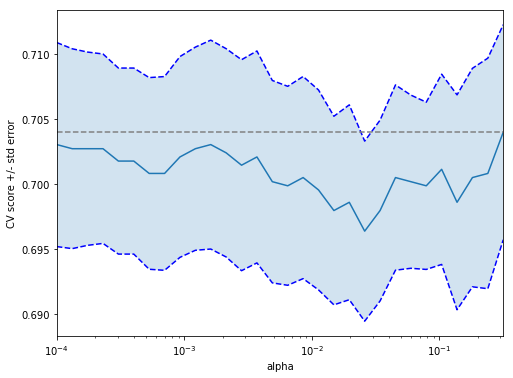

In [28]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

plt.show()

## Criando e salvando o modelo com os melhores parâmetros:

In [29]:
modelo = MultinomialNB(alpha=0.31622776601683794)
modelo.fit(X_train, y_train)

MultinomialNB(alpha=0.31622776601683794, class_prior=None, fit_prior=True)

In [30]:
pred = modelo.predict(X_test)

In [31]:
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.710


In [40]:
# Salvando a matriz esparsa
filename = 'outputs/tfidf_vec_claro.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

In [32]:
# Salvando o modelo
filename = 'outputs/modelo_multinomialnb.sav'
pickle.dump(modelo, open(filename, 'wb'))

In [35]:
# Carregando o modelo
filename = 'outputs/modelo_multinomialnb.sav'
modelo = pickle.load(open(filename, 'rb'))

In [41]:
# Carregando a matriz esparsa
filename = 'outputs/tfidf_vec_claro.sav'
vect = pickle.load(open(filename, 'rb'))

In [36]:
modelo

MultinomialNB(alpha=0.31622776601683794, class_prior=None, fit_prior=True)

In [44]:
teste = vect.transform(['Bom dia. Hoje o dia está lindo!'])

In [48]:
pred = modelo.predict(teste)

In [50]:
pred[0]

1

In [51]:
if pred[0] == -1:
    print('Sentimento Negativo')
elif pred[0] == 1:
    print('Sentimento Positivo')
else:
    print('Sentimento Neutro')

Sentimento Positivo
